# Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector


import json
%matplotlib inline

#Plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

### Helper visualise functions @Laura Lewis

In [2]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=82)
    plt.show()

## Loading Data

In [3]:
df = pd.read_csv('data/listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,71609,https://www.airbnb.com/rooms/71609,20221229070856,2022-12-29,city scrape,Ensuite Room (Room 1 & 2) near EXPO,For 3 rooms.Book room 1&2 and room 4<br /><br ...,NaN,https://a0.muscache.com/pictures/24453191/3580...,367042,...,4.78,4.26,4.32,NaN,f,6,0,6,0,0.15
1,71896,https://www.airbnb.com/rooms/71896,20221229070856,2022-12-29,city scrape,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,NaN,https://a0.muscache.com/pictures/2440674/ac4f4...,367042,...,4.43,4.17,4.04,NaN,t,6,0,6,0,0.17
2,71903,https://www.airbnb.com/rooms/71903,20221229070856,2022-12-29,city scrape,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",Quiet and view of the playground with exercise...,https://a0.muscache.com/pictures/568743/7bc623...,367042,...,4.64,4.50,4.36,NaN,f,6,0,6,0,0.33
3,275343,https://www.airbnb.com/rooms/275343,20221229070856,2022-12-29,city scrape,Amazing Room with window 10min to Redhill,Awesome location and host <br />Room near INSE...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,1439258,...,4.42,4.53,4.63,S0399,f,46,2,44,0,0.19
4,275344,https://www.airbnb.com/rooms/275344,20221229070856,2022-12-29,city scrape,15 mins to Outram MRT Single Room,Lovely home for the special guest !<br /><br /...,Bus stop <br />Food center <br />Supermarket,https://a0.muscache.com/pictures/miso/Hosting-...,1439258,...,4.54,4.62,4.46,S0399,f,46,2,44,0,0.11


In [4]:
print("Data type:", type(df))
print("Data dimensions: ", df.shape) #3037 rows and 75 columns 

Data type: <class 'pandas.core.frame.DataFrame'>
Data dimensions:  (3037, 75)


## Drop unnecessary columns

Columns that do not add any useful information can be removed.

In [5]:
# Only keep important columns
drop_cols = ['id','listing_url','scrape_id','last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_response_time', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'bathrooms_text', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
df.drop(columns=drop_cols, axis=1, inplace=True)

## Dealing with missing data

In [6]:
display(df.isnull().mean()) # Missing data

host_since                      0.000000
host_response_rate              0.203820
neighbourhood_cleansed          0.000000
neighbourhood_group_cleansed    0.000000
latitude                        0.000000
longitude                       0.000000
property_type                   0.000000
room_type                       0.000000
accommodates                    0.000000
bathrooms                       1.000000
bedrooms                        0.100428
beds                            0.029635
amenities                       0.000000
price                           0.000000
availability_365                0.000000
number_of_reviews               0.000000
review_scores_rating            0.425091
review_scores_accuracy          0.436286
review_scores_cleanliness       0.435957
review_scores_checkin           0.435957
review_scores_communication     0.435627
review_scores_location          0.436286
review_scores_value             0.436286
dtype: float64

In [7]:
#Create a list of missing values by each feature
temp = list(df.isna().sum())

#Create a list of columns and their missing values as inner list to a separate list
lst= []
i=0
for col in df.columns:
    insert_lst = [col,temp[i]]
    lst.append(insert_lst)
    i+=1

#Create a dataframe
temp_df = pd.DataFrame(data=lst,columns=['Column_Name','Missing_Values'])

fig = px.bar(temp_df.sort_values(by='Missing_Values'),x='Missing_Values',y='Column_Name',
             orientation='h',height=1000,width=1050,color='Missing_Values',text='Missing_Values',title='Missing values in train dataset')
fig.update_traces(textposition='outside')
fig.show()

### Data Formatting

In [8]:
print("Before cleaning:", df.price.count(), df.price.dtype)
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
print("After cleaning:", df.price.count(), df.price.dtype)

Before cleaning: 3037 object
After cleaning: 3037 float64


### Some visualisation

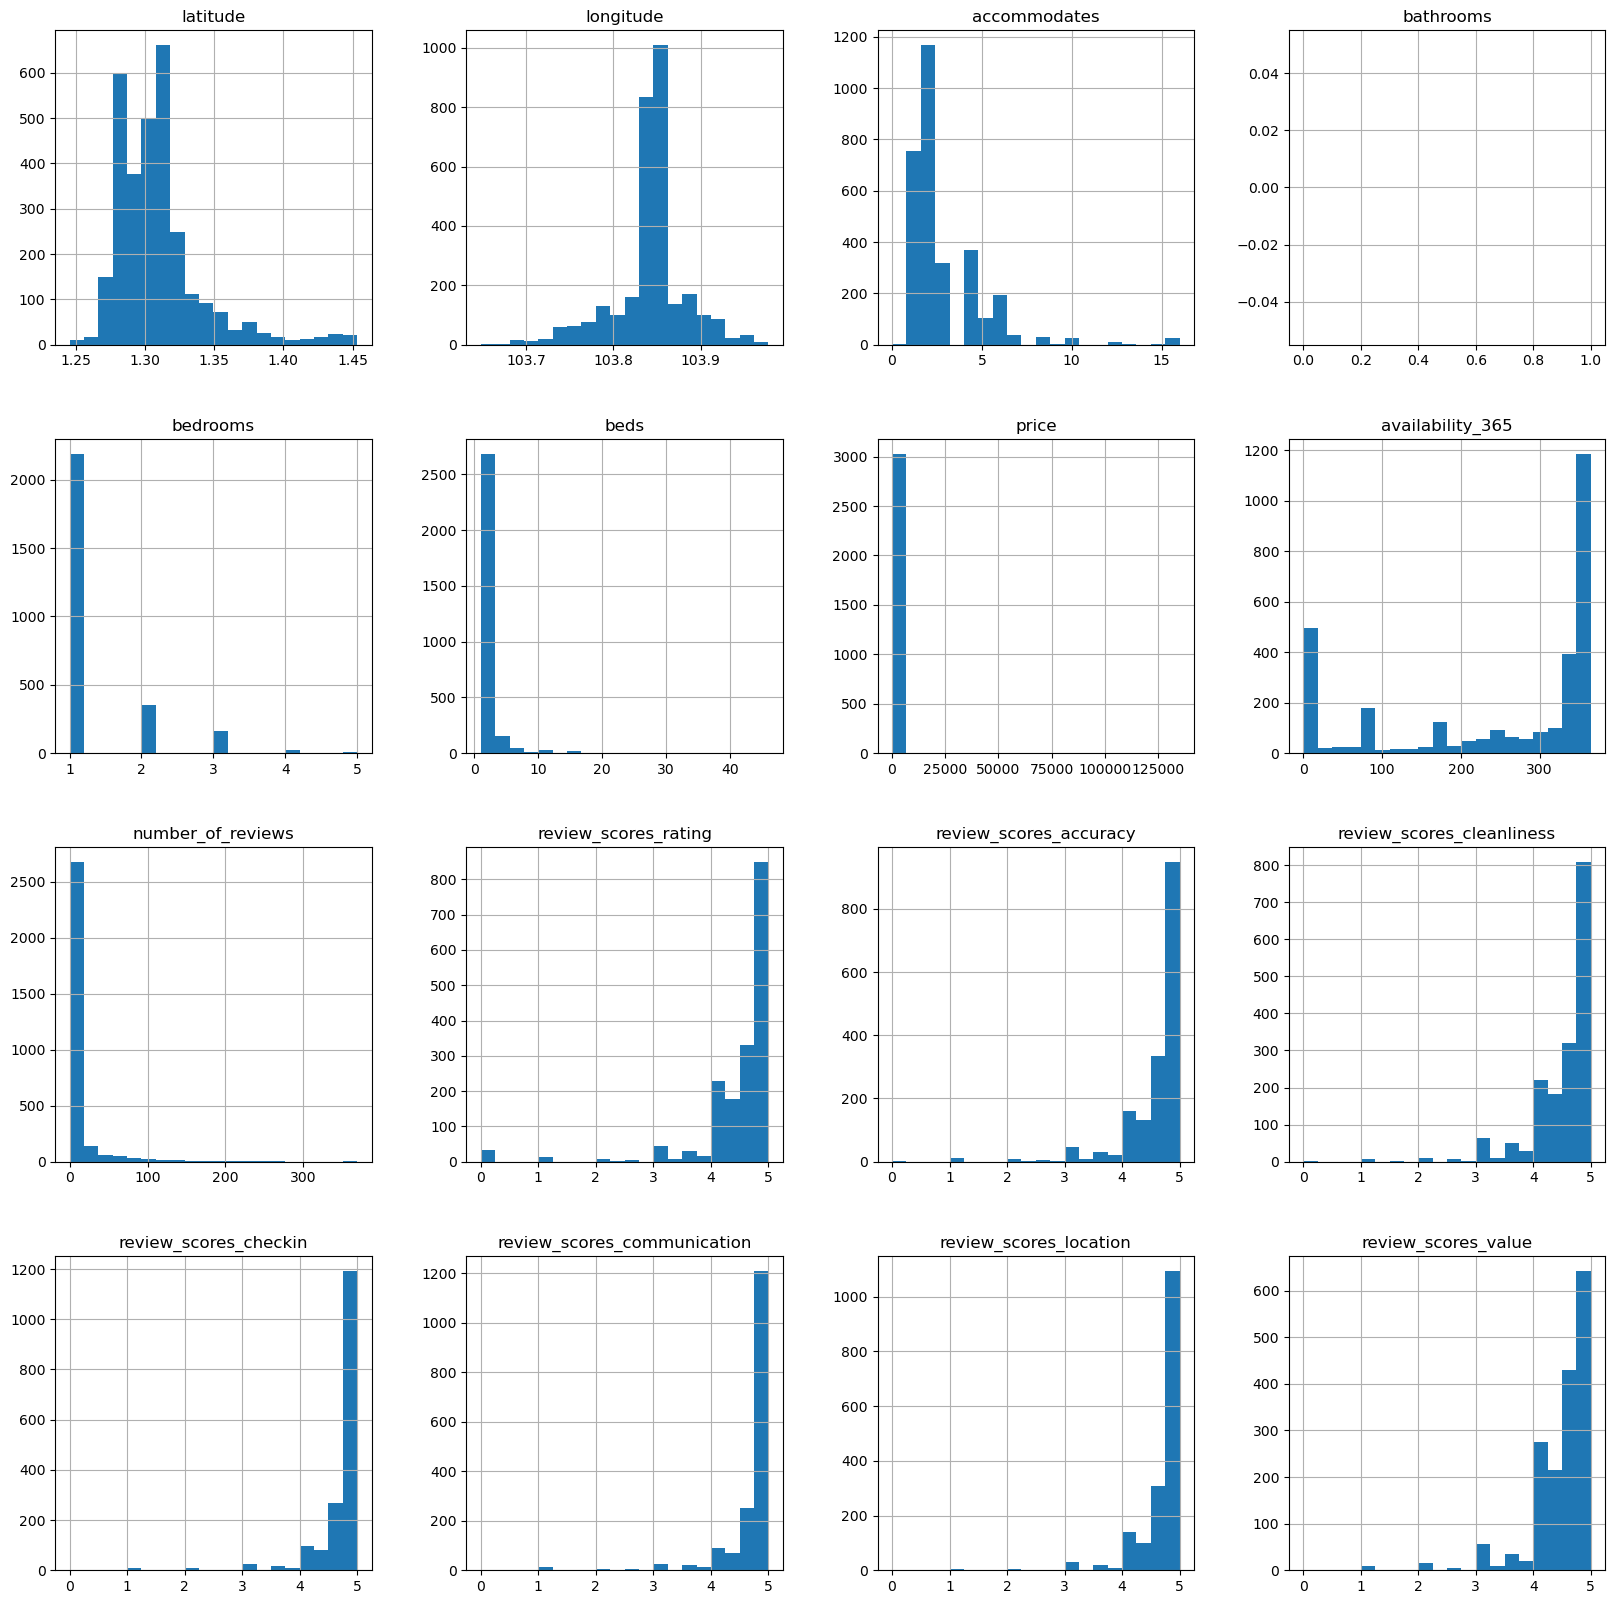

In [9]:
df.hist(figsize=(20,20), bins=20); # Represent counts of each type per data columns

### Fixing missing values (Imputer)

Missing values for bedrooms, and beds are replaced with the median. Bathrooms are all empty.

In [10]:
for col in ['bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

df.drop(columns=['bathrooms'], inplace=True)

In [11]:
df['property_type'].value_counts()

Private room in rental unit           589
Entire condo                          451
Entire rental unit                    377
Entire serviced apartment             372
Private room in condo                 256
Room in hotel                         172
Room in boutique hotel                137
Private room in home                  135
Room in hostel                         64
Private room in townhouse              52
Shared room in hostel                  51
Private room in serviced apartment     43
Room in aparthotel                     40
Private room in bungalow               31
Private room in hostel                 29
Private room in bed and breakfast      24
Entire home                            22
Shared room in rental unit             21
Private room                           18
Room in serviced apartment             15
Private room in villa                  13
Shared room in bed and breakfast       13
Entire loft                            12
Private room in guesthouse        

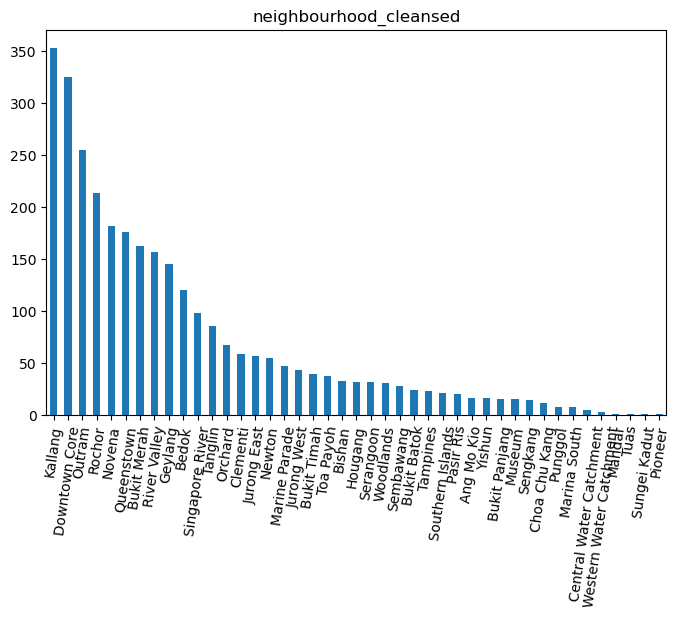

Kallang                    0.116233
Downtown Core              0.107014
Outram                     0.083964
Rochor                     0.070464
Novena                     0.059928
Queenstown                 0.057952
Bukit Merah                0.053671
River Valley               0.051696
Geylang                    0.047744
Bedok                      0.039513
Singapore River            0.032269
Tanglin                    0.028317
Orchard                    0.022061
Clementi                   0.019427
Jurong East                0.018769
Newton                     0.018110
Marine Parade              0.015476
Jurong West                0.014159
Bukit Timah                0.012842
Toa Payoh                  0.012183
Bishan                     0.010866
Hougang                    0.010537
Serangoon                  0.010537
Woodlands                  0.010207
Sembawang                  0.009220
Bukit Batok                0.007903
Tampines                   0.007573
Southern Islands           0

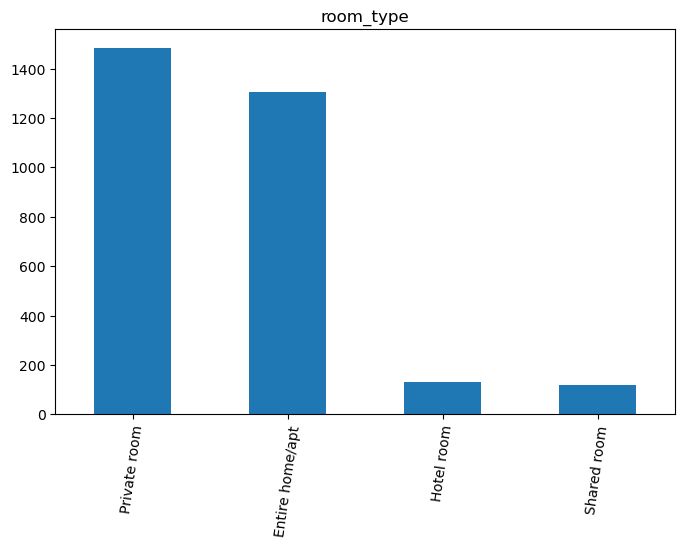

Private room       0.488969
Entire home/apt    0.430030
Hotel room         0.042476
Shared room        0.038525
Name: room_type, dtype: float64


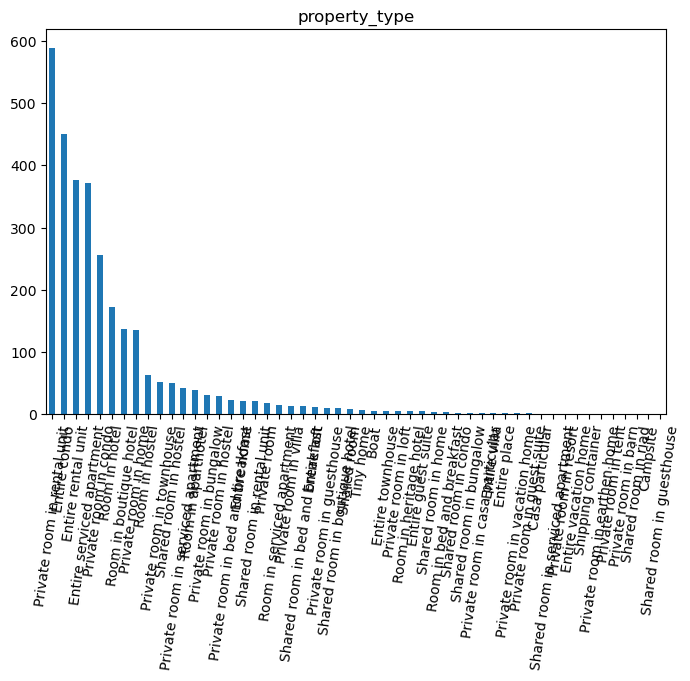

Private room in rental unit           0.193941
Entire condo                          0.148502
Entire rental unit                    0.124136
Entire serviced apartment             0.122489
Private room in condo                 0.084294
Room in hotel                         0.056635
Room in boutique hotel                0.045110
Private room in home                  0.044452
Room in hostel                        0.021073
Private room in townhouse             0.017122
Shared room in hostel                 0.016793
Private room in serviced apartment    0.014159
Room in aparthotel                    0.013171
Private room in bungalow              0.010207
Private room in hostel                0.009549
Private room in bed and breakfast     0.007903
Entire home                           0.007244
Shared room in rental unit            0.006915
Private room                          0.005927
Room in serviced apartment            0.004939
Private room in villa                 0.004281
Shared room i

In [12]:
for col in ['neighbourhood_cleansed', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=True))

In [13]:
# Sort them to either houses, apartments or hotels
df['property_type'].replace({
    'Private room in rental unit': 'Apartment',
    'Entire condo': 'Apartment',
    'Entire rental unit': 'House',
    'Entire serviced apartment': 'Apartment',
    'Private room in condo': 'Apartment',
    'Room in hotel': 'Hotel',
    'Room in boutique hotel': 'Hotel',
    'Private room in home': 'House',
    'Room in hostel': 'Hotel',
    'Private room in townhouse': 'House',
    'Shared room in hostel': 'Hotel',
    'Private room in serviced apartment': 'Apartment',
    'Room in aparthotel': 'Hotel',
    'Private room in bungalow': 'House',
    'Private room in hostel': 'Hotel',
    'Private room in bed and breakfast': 'Hotel',
    'Entire home': 'House',
    'Shared room in rental unit': 'House'
}, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment', 'Hotel']), 'property_type'] = 'Other'

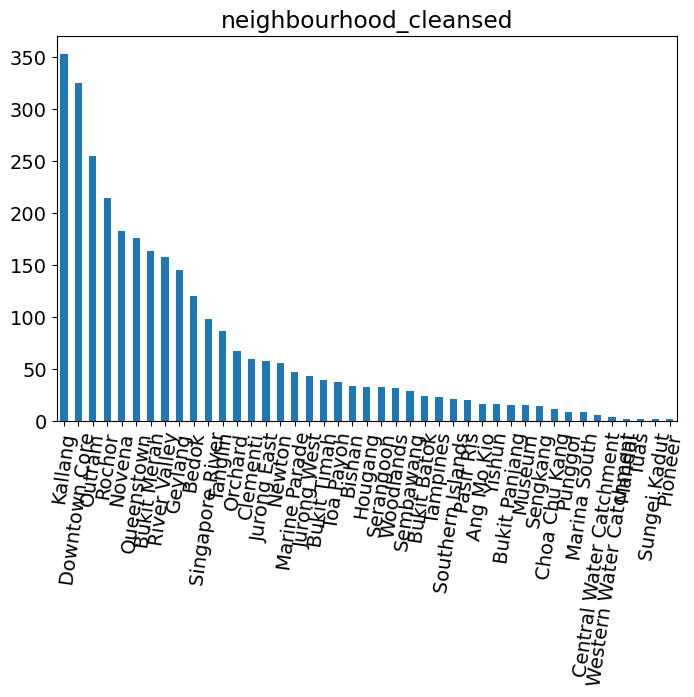

Kallang                    353
Downtown Core              325
Outram                     255
Rochor                     214
Novena                     182
Queenstown                 176
Bukit Merah                163
River Valley               157
Geylang                    145
Bedok                      120
Singapore River             98
Tanglin                     86
Orchard                     67
Clementi                    59
Jurong East                 57
Newton                      55
Marine Parade               47
Jurong West                 43
Bukit Timah                 39
Toa Payoh                   37
Bishan                      33
Hougang                     32
Serangoon                   32
Woodlands                   31
Sembawang                   28
Bukit Batok                 24
Tampines                    23
Southern Islands            21
Pasir Ris                   20
Ang Mo Kio                  16
Yishun                      16
Bukit Panjang               15
Museum  

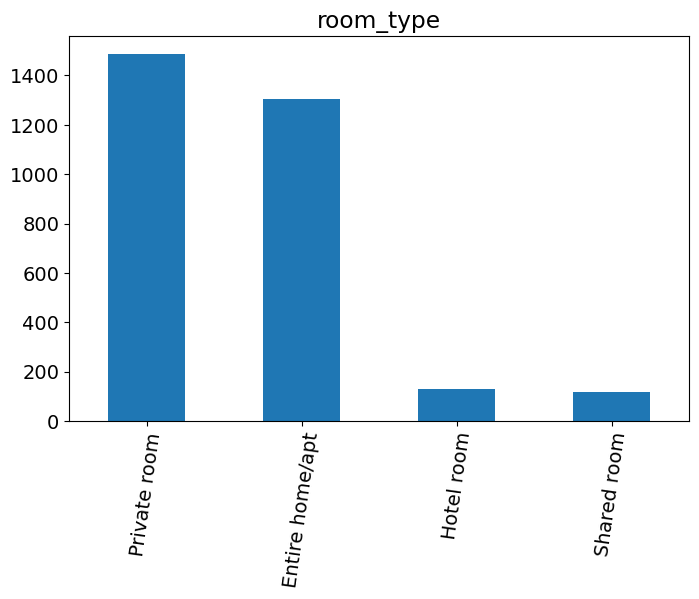

Private room       1485
Entire home/apt    1306
Hotel room          129
Shared room         117
Name: room_type, dtype: int64


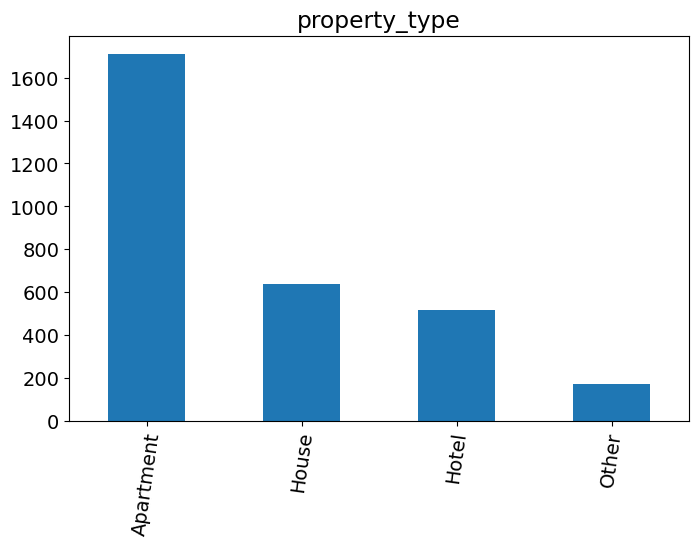

Apartment    1711
House         638
Hotel         517
Other         171
Name: property_type, dtype: int64


In [14]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
for col in ['neighbourhood_cleansed', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=False))

## Unpack amenities (One-Hot Encoding)

In [15]:
amenities_set = set()
# # Creating a set of all possible amenities
amenities_json = df.amenities.apply(json.loads)
amenities_list = ["|".join(x) for x in list(amenities_json)]

for amenities in amenities_list:
    for amenity in amenities.split(sep="|"):
        amenities_set.add(amenity)

pd.Series(list(amenities_set))

0                                 Golf course view
1      Paid parking garage on premises – 20 spaces
2                  AC - split type ductless system
3                       Coffee maker: french press
4                                      Valley view
                          ...                     
444                       32" HDTV with Chromecast
445                Free parking garage on premises
446                                     Bosch oven
447                     Aigner / Ferragamo shampoo
448                               Private entrance
Length: 449, dtype: object

In [16]:
unique_amenities = list(amenities_set)
# Add columns for each amenity and fill it with boolean if the amenity exists in each row.
remember_row = len(df.columns)
print(f"Before insertion {len(df.columns)} columns")
x = [pd.Series(df['amenities'].str.contains(amenity, regex=False), name=amenity) for amenity in unique_amenities]
df = pd.concat([df] + x, axis=1)
df[unique_amenities] = df[unique_amenities].fillna(0)

print(f"After insertion {len(df.columns)} columns")
df.head(30)

Before insertion 22 columns
After insertion 471 columns


,host_since,host_response_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,...,Clothing storage: dresser,Lake view,Children’s books and toys for ages 0-2 years old,"Private hot tub - available all year, open 24 hours",Fast wifi – 137 Mbps,"32"" HDTV with Chromecast",Free parking garage on premises,Bosch oven,Aigner / Ferragamo shampoo,Private entrance
0,2011-01-29,90%,Tampines,East Region,1.34537,103.95887,Other,Private room,6,2.0,...,False,False,False,False,False,False,False,False,False,True
1,2011-01-29,90%,Tampines,East Region,1.34754,103.95958,House,Private room,1,1.0,...,False,False,False,False,False,False,False,False,False,True
2,2011-01-29,90%,Tampines,East Region,1.34531,103.96100,House,Private room,2,1.0,...,False,False,False,False,False,False,False,False,False,False
3,2011-11-24,100%,Bukit Merah,Central Region,1.29015,103.80814,Apartment,Private room,1,1.0,...,False,False,False,False,False,False,False,False,False,False
4,2011-11-24,100%,Bukit Merah,Central Region,1.28836,103.81144,Apartment,Private room,1,1.0,...,False,False,False,False,False,False,False,False,False,False
5,2011-01-29,90%,Tampines,East Region,1.34490,103.95979,House,Private room,4,3.0,...,False,False,False,False,False,False,False,False,False,True
6,2011-12-20,86%,Newton,Central Region,1.31142,103.83924,Apartment,Private room,2,1.0,...,False,False,False,False,False,False,False,False,False,False
7,2011-11-24,100%,Bukit Merah,Central Region,1.28828,103.81020,Apartment,Private room,1,1.0,...,False,False,False,False,False,False,False,False,False,False
8,2011-11-24,100%,Bukit Merah,Central Region,1.28652,103.81225,Apartment,Private room,1,1.0,...,False,False,False,False,False,False,False,False,False,False
9,2011-11-24,100%,Bukit Merah,Central Region,1.28636,103.81138,Apartment,Private room,1,1.0,...,False,False,False,False,False,False,False,False,False,False


### Remove mostly empty columns (from amenities encoding)
Any column that has mostly true or mostly false values can be treated as a constant, and hence dropped.

In [17]:
# A filter to remove all columns with > 90% false values or > 90% true values (constant).
to_be_removed = []

for col in df.iloc[:, remember_row:].columns:
    if (df[col].mean() > 0.9) or (df[col].mean() < 0.1):
        to_be_removed.append(col)
display(pd.Series(to_be_removed))
print(f"Number of cols removed {len(to_be_removed)}")

df.drop(columns=to_be_removed, axis=1, inplace=True)

0                                 Golf course view
1      Paid parking garage on premises – 20 spaces
2                  AC - split type ductless system
3                       Coffee maker: french press
4                                      Valley view
                          ...                     
391                           Fast wifi – 137 Mbps
392                       32" HDTV with Chromecast
393                Free parking garage on premises
394                                     Bosch oven
395                     Aigner / Ferragamo shampoo
Length: 396, dtype: object

Number of cols removed 396


In [18]:
df.drop('amenities', axis=1, inplace=True)
df.head()

,host_since,host_response_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,...,Keypad,Hot water,Oven,Free street parking,Kitchen,Refrigerator,Pool,Extra pillows and blankets,Coffee,Private entrance
0,2011-01-29,90%,Tampines,East Region,1.34537,103.95887,Other,Private room,6,2.0,...,True,True,False,True,True,True,False,False,False,True
1,2011-01-29,90%,Tampines,East Region,1.34754,103.95958,House,Private room,1,1.0,...,True,True,False,True,True,True,False,False,True,True
2,2011-01-29,90%,Tampines,East Region,1.34531,103.96100,House,Private room,2,1.0,...,True,True,False,True,True,False,False,False,True,False
3,2011-11-24,100%,Bukit Merah,Central Region,1.29015,103.80814,Apartment,Private room,1,1.0,...,True,True,False,False,True,False,False,False,False,False
4,2011-11-24,100%,Bukit Merah,Central Region,1.28836,103.81144,Apartment,Private room,1,1.0,...,False,True,False,False,True,False,False,False,False,False


In [19]:
col = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']
df[col] = df[col].astype('category')

transformer = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category")
     ), remainder='passthrough', verbose_feature_names_out=False)
transformed = transformer.fit_transform(df)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [20]:
df.head()

,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,neighbourhood_cleansed_Clementi,...,Keypad,Hot water,Oven,Free street parking,Kitchen,Refrigerator,Pool,Extra pillows and blankets,Coffee,Private entrance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,True,False,True,True,True,False,False,False,True
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,True,False,True,True,True,False,False,True,True
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,True,False,True,True,False,False,False,True,False
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,True,True,False,False,True,False,False,False,False,False
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False


### Change the date to year difference

In [21]:
import datetime
thisYear = datetime.date.today().year
df['host_since_years'] = thisYear - pd.DatetimeIndex(df['host_since']).year
df.drop(columns=['host_since'], inplace=True)

### Replace host response rate percentage sign to numerical float

In [22]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float') / 100.0

### Replace all the missing values with 0. The reason we are not replacing the missing values with mean/median value is because the customers might have not give their reviews because they are not satisfied with the service. 

In [23]:
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)
df['review_scores_accuracy'] = df['review_scores_accuracy'].fillna(0)
df['review_scores_cleanliness'] = df['review_scores_cleanliness'].fillna(0)
df['review_scores_checkin'] = df['review_scores_checkin'].fillna(0)
df['review_scores_communication'] = df['review_scores_communication'].fillna(0)
df['review_scores_location'] = df['review_scores_location'].fillna(0)
df['review_scores_value'] = df['review_scores_value'].fillna(0) 

## Trim outliers and $0 rental prices

In [24]:
# Remove $0 rental
df = df.query('price != 0')
# Remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]

# Feature Engineering

Warning: Latitude and Longitude from OpenStreetMap is randomised by maximum of 400m for anonymity. -Source: Airbnb Data Dictionary

Load point data from OpenStreetMap

In [25]:
city = gpd.read_file('data/singapore.geojson')
common_filter = lambda x: ['osm_id', 'name', 'ref', f'{x}', 'other_tags', 'geometry']
city.head()

,osm_id,name,ref,amenity,highway,shop,leisure,railway,other_tags,geometry
0,25451918,NaN,2A,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.97394 1.32757)
1,25455287,NaN,14A,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.87400 1.29544)
2,25455292,NaN,10B,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.90850 1.30101)
3,25455304,NaN,1,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.97848 1.33468)
4,26778790,NaN,NaN,NaN,traffic_signals,NaN,NaN,NaN,NaN,POINT (103.85002 1.30152)


Filter out dataframe for different amenities, such as (MRT, bus stops, malls, schools, food places)

In [26]:
mrt = city.filter(items=common_filter('railway'))
mrt.query('railway == "station"', inplace=True)

bus = city.filter(items=common_filter('highway'))
bus.query('highway == "bus_stop"', inplace=True)

mall = city.filter(items=common_filter('shop'))
mall.query('shop == "mall"', inplace=True)

school = city.filter(items=common_filter('amenity'))
school.query('amenity == "school"', inplace=True)

food = city.filter(items=common_filter('amenity'))
food.query('amenity == "food_restaurant" | amenity == "restaurant"', inplace=True)

<Axes: >

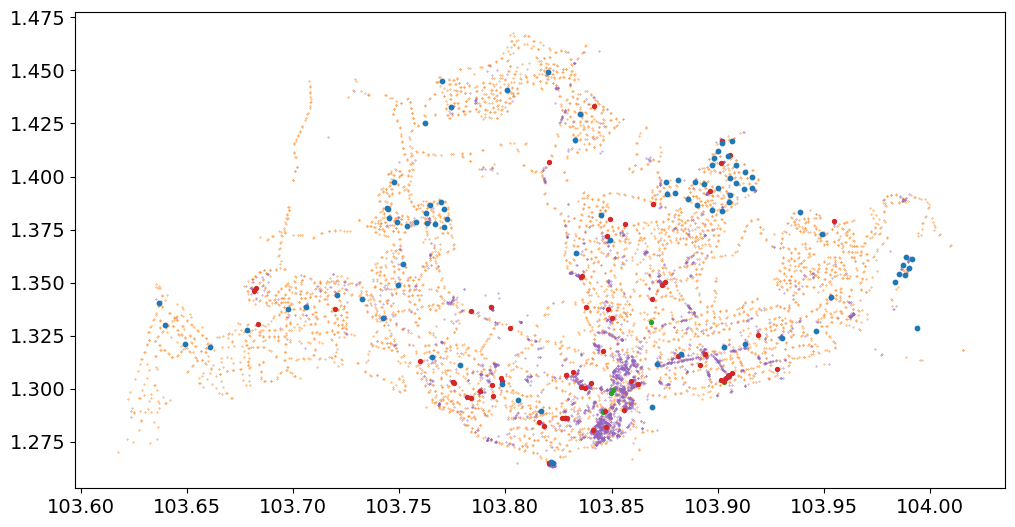

In [27]:
fig, ax = plt.subplots(figsize=(12,16))
ax.set_aspect('equal')
mrt.plot(ax=ax, legend=True, markersize = 10, zorder=10)
bus.plot(ax=ax, legend=True, markersize = 0.1, zorder=1)
mall.plot(ax=ax, legend=True, markersize = 8, zorder=3)
school.plot(ax=ax, legend=True, markersize = 8, zorder=3)
food.plot(ax=ax, legend=True, markersize = 0.1, zorder=2)

Find distance from the closest amenity

In [28]:
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].astype('float64')

In [29]:
# Creates new columns converting coordinate degrees to radians.
def degree_to_radians(data: gpd.GeoDataFrame)->None:
    if not {'latitude', 'longitude'}.issubset(data.columns):
        geometry_to_coordinates(data)
    for column in ['latitude','longitude']:
        data[column] = np.deg2rad(data[column].values)

def geometry_to_coordinates(data: gpd.GeoDataFrame)->None:
    data['longitude'] = data.geometry.x
    data['latitude'] = data.geometry.y

def find_closest(data: gpd.GeoDataFrame, name="_")->pd.Series:
    # Check if 'lat' and 'lon' exists in data and df
    if not {'latitude','longitude'}.issubset(data.columns):
        degree_to_radians(data)
    # Construct ball tree
    bT = BallTree(data[['latitude', 'longitude']].values, metric='haversine')
    # Grab the first nearest neighbour (distance only)
    distances, _ = bT.query(df[['latitude', 'longitude']].values, k=1)
    # Convert distances to km
    distances = np.squeeze(distances)
    convert_to_km = np.vectorize(lambda x: x * 6371)
    distances = convert_to_km(distances)
    return pd.Series(distances, name=name)

# Convert dataset to radians
degree_to_radians(df)

df.reset_index(inplace=True)

df = pd.concat([df, find_closest(mrt, "distance_from_MRT")], axis=1)
df = pd.concat([df, find_closest(bus, "distance_from_Bus")], axis=1)
df = pd.concat([df, find_closest(mall, "distance_from_Mall")], axis=1)
df = pd.concat([df, find_closest(school, "distance_from_School")], axis=1)
df = pd.concat([df, find_closest(food, "distance_from_Food")], axis=1)

# Back to degrees
for column in ['latitude', 'longitude']:
    df[column] = np.rad2deg(df[column].values)

In [30]:
df.head(25)

,index,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,...,Pool,Extra pillows and blankets,Coffee,Private entrance,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,True,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,12,0.738518,0.210803,7.816646,3.809634,0.506811
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,12,3.478741,0.080014,1.864890,0.916637,0.350748
6,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.745792,0.104505,4.000537,0.788601,0.148269
7,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.610914,0.029546,3.781908,0.491153,0.124848
8,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.701718,0.039040,3.879678,0.569143,0.143793
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,True,False,12,1.069078,0.327217,8.203803,3.362290,0.605548


In [31]:
# Feature Selection


# Save to new csv

In [32]:
# Remove index from df then save
df.drop(['index'], axis=1, inplace=True)
df.to_csv('data/clean_listing.csv')